In [1]:

import sys, os, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_CSV = "diabetic_data.csv"

# Output dirs
EDA_DIR = Path("eda_outputs"); PLOTS = EDA_DIR/"plots"
EDA_DIR.mkdir(parents=True, exist_ok=True); PLOTS.mkdir(parents=True, exist_ok=True)

# ============================
# A1) Load + quick clean
# ============================
df = pd.read_csv(DATA_CSV)
raw_shape = df.shape
df = df.replace("?", np.nan)
df["target"] = (df["readmitted"] == "<30").astype(int)

print("Raw shape:", raw_shape)
print("Target (<30) rate:", df["target"].mean().round(4))

# ============================
# A2) Types & missingness
# ============================
dtypes = df.dtypes.astype(str).reset_index().rename(columns={"index":"column",0:"dtype"})
dtypes.to_csv(EDA_DIR/"dtypes.csv", index=False)

na_counts = df.isna().sum()
na_pct = (na_counts/len(df)*100).round(2)
na_table = (pd.DataFrame({"column": na_counts.index,
                          "missing_count": na_counts.values,
                          "missing_pct": na_pct.values})
            .sort_values("missing_count", ascending=False))
na_table.to_csv(EDA_DIR/"missingness.csv", index=False)

display(dtypes.head(10))
display(na_table.head(15))

# ============================
# A3) Categorical summaries
# ============================
cat_cols = ["race","gender","age","admission_type_id","discharge_disposition_id",
            "admission_source_id","diabetesMed","change"]
for c in cat_cols:
    if c in df.columns:
        vc = df[c].value_counts(dropna=False).rename_axis(c).to_frame("count")
        vc["pct"] = (vc["count"]/len(df)*100).round(2)
        vc.reset_index().to_csv(EDA_DIR/f"cat_{c}.csv", index=False)

# ============================
# A4) Numeric summaries + hists
# ============================
num_cols = ["time_in_hospital","num_lab_procedures","num_procedures","num_medications",
            "number_outpatient","number_emergency","number_inpatient","number_diagnoses"]
num_desc = {}
for c in num_cols:
    if c in df.columns:
        num_desc[c] = df[c].describe().to_dict()
        plt.figure()
        df[c].dropna().astype(float).plot(kind="hist", bins=30)
        plt.title(f"Histogram of {c}"); plt.xlabel(c); plt.ylabel("Count")
        plt.tight_layout(); plt.savefig(PLOTS/f"hist_{c}.png"); plt.close()
json.dump(num_desc, open(EDA_DIR/"numeric_describe.json","w"), indent=2)

# ============================
# A5) Outcome rate by subgroups
# ============================
def rate_by(col):
    t = (df.groupby(col)["target"].agg(["count","mean"])
         .rename(columns={"mean":"readmit_rate"}).reset_index()
         .sort_values("readmit_rate", ascending=False))
    t["readmit_rate"] = (t["readmit_rate"]*100).round(2)
    return t

if "race" in df.columns:
    by_race = rate_by("race"); by_race.to_csv(EDA_DIR/"rate_by_race.csv", index=False)
    plt.figure(); plt.bar(by_race["race"].astype(str), by_race["readmit_rate"])
    plt.xticks(rotation=60, ha="right"); plt.ylabel("Readmit <30 rate (%)"); plt.title("Rate by race")
    plt.tight_layout(); plt.savefig(PLOTS/"rate_by_race.png"); plt.close()
if "gender" in df.columns:
    by_gender = rate_by("gender"); by_gender.to_csv(EDA_DIR/"rate_by_gender.csv", index=False)
    plt.figure(); plt.bar(by_gender["gender"].astype(str), by_gender["readmit_rate"])
    plt.ylabel("Readmit <30 rate (%)"); plt.title("Rate by gender")
    plt.tight_layout(); plt.savefig(PLOTS/"rate_by_gender.png"); plt.close()
if "age" in df.columns:
    by_age = rate_by("age"); by_age.to_csv(EDA_DIR/"rate_by_age.csv", index=False)
    plt.figure(); plt.bar(by_age["age"].astype(str), by_age["readmit_rate"])
    plt.xticks(rotation=45, ha="right"); plt.ylabel("Readmit <30 rate (%)"); plt.title("Rate by age")
    plt.tight_layout(); plt.savefig(PLOTS/"rate_by_age.png"); plt.close()

# ============================
# A6) Diagnosis prefix exploration
# ============================
def diag_prefix_table(col, topn=20):
    if col not in df.columns: return None
    s = df[col].dropna().astype(str).str.upper().str.strip()
    s = s.replace({"NONE":"", "":np.nan}).dropna()
    pref = s.str.slice(0,3)
    return (pref.value_counts().head(topn)
            .rename_axis(f"{col}_prefix").to_frame("count").reset_index())

for dcol in ["diag_1","diag_2","diag_3"]:
    tbl = diag_prefix_table(dcol)
    if tbl is not None:
        tbl.to_csv(EDA_DIR/f"top_{dcol}_prefix.csv", index=False)
        plt.figure(); plt.bar(tbl[f"{dcol}_prefix"].astype(str), tbl["count"])
        plt.xticks(rotation=60, ha="right"); plt.ylabel("Count"); plt.title(f"Top {dcol} prefixes")
        plt.tight_layout(); plt.savefig(PLOTS/f"top_{dcol}_prefix.png"); plt.close()

# ============================
# A7) Human-readable summary
# ============================
lines = [
    f"Raw shape: {raw_shape[0]} rows, {raw_shape[1]} columns",
    f"Target (<30) prevalence: {df['target'].mean()*100:.2f}%"
]
Path(EDA_DIR/"EDA_summary.txt").write_text("\n".join(lines))
print("EDA complete. See eda_outputs/ folder (CSVs + plots).")


Raw shape: (101766, 50)
Target (<30) rate: 0.1116


,column,dtype
0,encounter_id,int64
1,patient_nbr,int64
2,race,object
3,gender,object
4,age,object
5,weight,object
6,admission_type_id,int64
7,discharge_disposition_id,int64
8,admission_source_id,int64
9,time_in_hospital,int64


,column,missing_count,missing_pct
5,weight,98569,96.86
22,max_glu_serum,96420,94.75
23,A1Cresult,84748,83.28
11,medical_specialty,49949,49.08
10,payer_code,40256,39.56
2,race,2273,2.23
20,diag_3,1423,1.40
19,diag_2,358,0.35
18,diag_1,21,0.02
1,patient_nbr,0,0.00


EDA complete. See eda_outputs/ folder (CSVs + plots).


,feature,importance
1651,diag_3_273,1.539453
261,diag_1_263,1.509919
337,diag_1_356,1.503580
264,diag_1_271,1.450123
890,diag_2_250.1,1.443643
1217,diag_2_625,1.418823
808,diag_1_V58,1.400926
971,diag_2_307,1.399401
1546,diag_3_156,1.394111
824,diag_2_136,1.361317


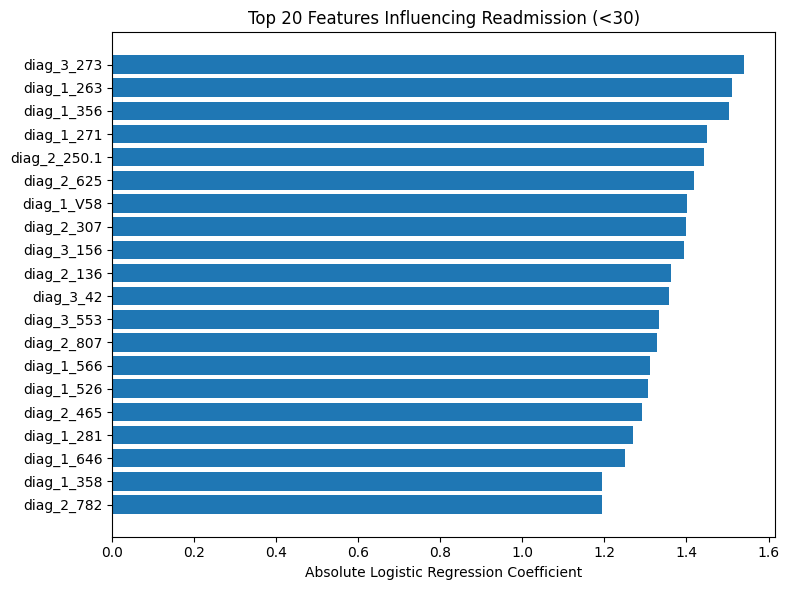

In [2]:
# ===============================
# A8) Feature Importance Analysis
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np

# 1. Prepare data
df_model = df.copy()
X = df_model.drop(columns=["readmitted", "target"])
y = df_model["target"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]


# 2. Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# 3. Logistic regression model
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=500))
])

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf.fit(X_train, y_train)

# 5. Get feature names and coefficients
encoder = clf.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = encoder.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, encoded_cat_features])
coefficients = clf.named_steps['model'].coef_[0]

importance = pd.DataFrame({
    'feature': all_features,
    'importance': np.abs(coefficients)
}).sort_values('importance', ascending=False)

importance.to_csv("eda_outputs/feature_importance.csv", index=False)
display(importance.head(20))

# Optional plot
plt.figure(figsize=(8,6))
plt.barh(importance.head(20)['feature'][::-1], importance.head(20)['importance'][::-1])
plt.title("Top 20 Features Influencing Readmission (<30)")
plt.xlabel("Absolute Logistic Regression Coefficient")
plt.tight_layout()
plt.savefig("eda_outputs/plots/feature_importance.png")
plt.show()


,feature,importance
73,medical_specialty_Hematology,1.115503
96,medical_specialty_Pediatrics-Endocrinology,0.769093
74,medical_specialty_Hematology/Oncology,0.703523
89,medical_specialty_Otolaryngology,0.698557
58,payer_code_WC,0.616369
83,medical_specialty_ObstetricsandGynecology,0.607930
22,age_[0-10),0.597971
173,rosiglitazone_Down,0.489301
68,medical_specialty_Endocrinology,0.472473
72,medical_specialty_Gynecology,0.459076


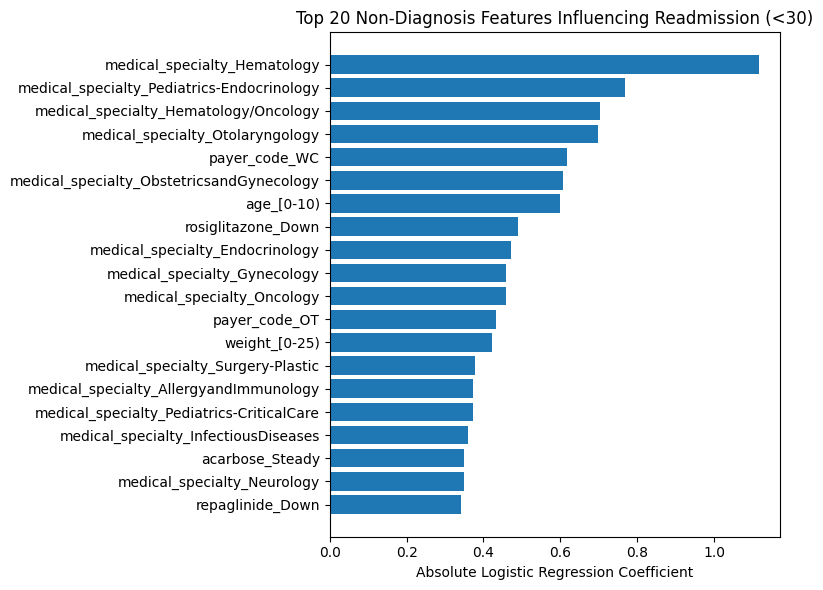

In [3]:
# ===============================
# A9) Feature Importance (Excluding Diagnosis Codes)
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Drop diagnosis columns to see what general features are most predictive
cols_to_drop = [c for c in df.columns if c.startswith("diag_")]
df_no_diag = df.drop(columns=cols_to_drop)

X = df_no_diag.drop(columns=["readmitted", "target"])
y = df_no_diag["target"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Preprocess numeric & categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Logistic regression for interpretability
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=500))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
clf.fit(X_train, y_train)

# Extract importance
encoder = clf.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = encoder.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, encoded_cat_features])
coefficients = clf.named_steps['model'].coef_[0]

importance_no_diag = pd.DataFrame({
    'feature': all_features,
    'importance': np.abs(coefficients)
}).sort_values('importance', ascending=False)

importance_no_diag.to_csv("eda_outputs/feature_importance_no_diag.csv", index=False)
display(importance_no_diag.head(20))

plt.figure(figsize=(8,6))
plt.barh(importance_no_diag.head(20)['feature'][::-1], importance_no_diag.head(20)['importance'][::-1])
plt.title("Top 20 Non-Diagnosis Features Influencing Readmission (<30)")
plt.xlabel("Absolute Logistic Regression Coefficient")
plt.tight_layout()
plt.savefig("eda_outputs/plots/feature_importance_no_diag.png")
plt.show()


In [5]:
# ===========================================
# B0) Setup (install deps for Colab if needed)
# ===========================================
!pip -q install gradio==4.44.0 joblib==1.4.2 scikit-learn==1.5.2

import os, json, shutil, warnings
from dataclasses import dataclass, asdict
from pathlib import Path
import numpy as np, pandas as pd, joblib, gradio as gr

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Point to your CSV (Drive path OK)
DATA_CSV = "diabetic_data.csv"  # or "/content/drive/MyDrive/your_folder/diabetic_data.csv"

# Folders
OUTDIR   = Path("artifacts"); OUTDIR.mkdir(exist_ok=True, parents=True)
REG_DIR  = Path("models/registry"); REG_DIR.mkdir(exist_ok=True, parents=True)
POINTERS = Path("models/pointers"); POINTERS.mkdir(exist_ok=True, parents=True)
SPLIT_DIR= Path("splits"); SPLIT_DIR.mkdir(exist_ok=True, parents=True)
LOG_DIR  = Path("logs"); LOG_DIR.mkdir(exist_ok=True, parents=True)
# NEW: per-hospital prediction logs (simulated "local" hospital storage)
HOSPITAL_PRED_LOG_DIR = LOG_DIR / "hospital_predictions"
HOSPITAL_PRED_LOG_DIR.mkdir(exist_ok=True, parents=True)

# ===========================================
# B1) Helper functions (metrics, DP, weights)
# ===========================================
def expected_calibration_error(probs, labels, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    inds = np.digitize(probs, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = inds == b
        if not mask.any(): continue
        acc = labels[mask].mean()
        conf = probs[mask].mean()
        ece += abs(acc - conf) * (mask.mean())
    return float(ece)

def l2_clip_and_noise(delta_dict, clip_norm=1.0, sigma=0.4, rng=None):
    rng = rng or np.random
    vecs, shapes = [], {}
    for k, v in delta_dict.items():
        arr = v.reshape(-1); vecs.append(arr); shapes[k] = v.shape
    flat = np.concatenate(vecs) if vecs else np.array([])
    norm = np.linalg.norm(flat, ord=2) + 1e-12
    scale = min(1.0, clip_norm / norm)
    flat = flat * scale
    if flat.size > 0 and sigma > 0: flat = flat + rng.normal(0.0, sigma, size=flat.shape)
    out, idx = {}, 0
    for k, shape in shapes.items():
        size = np.prod(shape); out[k] = flat[idx:idx+size].reshape(shape); idx += size
    return out

def get_sgd(input_dim):
    clf = SGDClassifier(loss="log_loss", penalty="l2", alpha=1e-4,
                        learning_rate="optimal", max_iter=1, tol=None,
                        random_state=RANDOM_STATE)
    dummy_X = np.zeros((1, input_dim)); dummy_y = np.array([0])
    clf.partial_fit(dummy_X, dummy_y, classes=np.array([0,1]))
    return clf

def get_weights(clf): return {"coef_": clf.coef_.copy(), "intercept_": clf.intercept_.copy()}
def set_weights(clf, w): clf.coef_, clf.intercept_ = w["coef_"].copy(), w["intercept_"].copy()
def add_weights(w1, w2, alpha=1.0): return {k: w1[k] + alpha*w2[k] for k in w1}
def sub_weights(w1, w2): return {k: w1[k] - w2[k] for k in w1}
def weighted_fedavg(deltas, weights):
    keys = deltas[0].keys(); agg = {k: np.zeros_like(deltas[0][k]) for k in keys}
    for d, w in zip(deltas, weights):
        for k in keys: agg[k] += w*d[k]
    return agg

# ===========================================
# B2) Registry
# ===========================================
@dataclass
class ModelMeta:
    version: str
    status: str   # candidate | stable | rolled_back
    path: str
    metrics: dict
    schema_hash: str

def save_version(src_dir: Path, meta: ModelMeta):
    dst = REG_DIR / meta.version; dst.mkdir(parents=True, exist_ok=True)
    for f in src_dir.iterdir(): shutil.copy2(f, dst / f.name)
    json.dump(asdict(meta), open(dst/"meta.json","w"), indent=2)

def read_meta(version: str) -> ModelMeta:
    return ModelMeta(**json.load(open(REG_DIR/version/"meta.json")))

def set_pointer(name: str, version: str):
    json.dump({"version": version}, open(POINTERS/f"{name}.json","w"))

def get_pointer(name: str, default=None):
    p = POINTERS/f"{name}.json"
    return json.load(open(p))["version"] if p.exists() else default

def list_versions(status=None):
    out=[]
    for d in sorted(REG_DIR.iterdir()):
        m = d/"meta.json"
        if m.exists():
            meta = json.load(open(m))
            if status is None or meta["status"]==status: out.append(meta["version"])
    return out

from datetime import datetime, timedelta
import hashlib

# ---- Auth users (username -> {password, hospital_id}) ----
USERS = {
    "hospA": {"password": "A_password", "hospital_id": "A"},
    "hospB": {"password": "B_password", "hospital_id": "B"},
    "hospC": {"password": "C_password", "hospital_id": "C"},
    "hospD": {"password": "D_password", "hospital_id": "D"},
}

# ---- Scheduling markers ----
SCHED_DIR = Path("schedules"); SCHED_DIR.mkdir(parents=True, exist_ok=True)

GLOBAL_REFRESH_MARK = SCHED_DIR / "global_last_refresh.json"  # for "monthly" refresh marker
LOCAL_LAST_PUSH_DIR = SCHED_DIR / "local_push"               # per-hospital weekly marker
LOCAL_LAST_PUSH_DIR.mkdir(exist_ok=True, parents=True)

def _read_json(path, default):
    return json.load(open(path)) if path.exists() else default

def _write_json(path, obj):
    json.dump(obj, open(path, "w"), indent=2)
# NEW: log a single prediction for a hospital (local-only, no raw data leaves)
def log_prediction(hospital_id: str, features: dict, prob: float, label_int: int, version: str):
    """
    Append one prediction row to that hospital's local log CSV.
    This simulates hospital-side storage: raw features never leave this folder.
    """
    if not hospital_id:
        return

    # Build one row
    from datetime import datetime  # safe even if imported below as well
    row = {
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "hospital_id": hospital_id,
        "model_version": version,
        "predicted_prob": float(prob),
        "predicted_label": int(label_int),
    }
    # include all raw feature values
    row.update(features)

    path = HOSPITAL_PRED_LOG_DIR / f"{hospital_id}_predictions.csv"
    df = pd.DataFrame([row])

    # Append or create
    if path.exists():
        df.to_csv(path, mode="a", header=False, index=False)
    else:
        df.to_csv(path, index=False)

# --------- Per-hospital pin/resolve ---------
def hospital_pin_path(hospital_id: str) -> Path:
    return POINTERS / f"pin_{hospital_id}.json"

def get_hospital_pin(hospital_id: str):
    p = hospital_pin_path(hospital_id)
    return json.load(open(p))["version"] if p.exists() else None

def set_hospital_pin(hospital_id: str, version: str):
    json.dump({"version": version}, open(hospital_pin_path(hospital_id), "w"))

def clear_hospital_pin(hospital_id: str):
    p = hospital_pin_path(hospital_id)
    if p.exists(): p.unlink()

def resolve_serving_version_for(hospital_id: str) -> str:
    """Pinned version if exists; otherwise global stable."""
    pinned = get_hospital_pin(hospital_id)
    if pinned: return pinned
    return get_pointer("global_stable", None)

# --------- Per-hospital serve history for rollback ---------
def hospital_history_path(hospital_id: str) -> Path:
    return LOG_DIR / f"serve_history_{hospital_id}.json"

def _load_hist(hospital_id: str):
    p = hospital_history_path(hospital_id)
    return json.load(open(p)) if p.exists() else []

def _save_hist(hospital_id: str, hist):
    json.dump(hist, open(hospital_history_path(hospital_id), "w"), indent=2)

def record_hospital_switch(hospital_id: str, old_ver: str, new_ver: str, who="admin-ui"):
    hist = _load_hist(hospital_id)
    hist.append({"ts": datetime.utcnow().isoformat()+"Z", "from": old_ver, "to": new_ver, "who": who})
    _save_hist(hospital_id, hist)

def rollback_hospital(hospital_id: str):
    hist = _load_hist(hospital_id)
    if not hist: return "No previous version for this hospital."
    last = hist[-1]
    prev = last.get("from")
    if not prev: return "No previous version recorded."
    if not (REG_DIR / prev).exists(): return f"Version {prev} not found."
    current = resolve_serving_version_for(hospital_id)
    set_hospital_pin(hospital_id, prev)
    record_hospital_switch(hospital_id, current, prev, who="rollback")
    return f"Hospital {hospital_id}: rolled back from {current} → {prev}"

def unpin_hospital(hospital_id: str):
    was = resolve_serving_version_for(hospital_id)
    clear_hospital_pin(hospital_id)
    now = resolve_serving_version_for(hospital_id)
    record_hospital_switch(hospital_id, was, now, who="unpin")
    return f"Hospital {hospital_id}: now following global ({now})"

def admin_switch_for_hospital(hospital_id: str, version: str):
    if not version: return "Choose a version."
    if not (REG_DIR / version).exists(): return f"Version {version} not found."
    current = resolve_serving_version_for(hospital_id)
    set_hospital_pin(hospital_id, version)
    if current != version:
        record_hospital_switch(hospital_id, current, version, who="admin-ui")
    return f"Hospital {hospital_id}: now serving {version}"


def _now_utc():
    return datetime.utcnow()

def _due(ts_str: str, every_days: int) -> bool:
    if not ts_str: return True
    last = datetime.fromisoformat(ts_str.replace("Z",""))
    return (_now_utc() - last) >= timedelta(days=every_days)

def maybe_monthly_global_refresh():
    mark = _read_json(GLOBAL_REFRESH_MARK, {"last": None})
    if _due(mark["last"], every_days=30):
        # Run a small federated update over existing splits to produce a fresh stable.
        # (fast path: 1-2 rounds)
        if not Path(DATA_CSV).exists():
            return "Global refresh skipped: dataset missing."
        A,B,C,D,_ = load_and_split(DATA_CSV)
        gclf, pre, schema, schema_hash, hist = federated_train_rounds(
            A,B,C,D, rounds=1, dp_clip=1.0, dp_sigma=0.4, version_seed="G.1.0.0"
        )
        mark["last"] = _now_utc().isoformat()+"Z"
        _write_json(GLOBAL_REFRESH_MARK, mark)
        return f"Global refreshed at {mark['last']} (auto)."
    return "Global refresh not due."

def maybe_weekly_local_push(hospital_id: str):
    p = LOCAL_LAST_PUSH_DIR / f"{hospital_id}.json"
    state = _read_json(p, {"last": None})
    if _due(state["last"], every_days=7):
        # Here you would train a tiny local step on hospital's newly logged data
        # and send a delta to server. For the demo, we only stamp time.
        state["last"] = _now_utc().isoformat()+"Z"
        _write_json(p, state)
        return f"Hospital {hospital_id}: local update pushed at {state['last']}."
    return f"Hospital {hospital_id}: local push not due."


def _now_utc():
    return datetime.utcnow()

def _due(ts_str: str, every_days: int) -> bool:
    if not ts_str: return True
    last = datetime.fromisoformat(ts_str.replace("Z",""))
    return (_now_utc() - last) >= timedelta(days=every_days)

def maybe_monthly_global_refresh():
    mark = _read_json(GLOBAL_REFRESH_MARK, {"last": None})
    if _due(mark["last"], every_days=30):
        # Run a small federated update over existing splits to produce a fresh stable.
        # (fast path: 1-2 rounds)
        if not Path(DATA_CSV).exists():
            return "Global refresh skipped: dataset missing."
        A,B,C,D,_ = load_and_split(DATA_CSV)
        gclf, pre, schema, schema_hash, hist = federated_train_rounds(
            A,B,C,D, rounds=1, dp_clip=1.0, dp_sigma=0.4, version_seed="G.1.0.0"
        )
        mark["last"] = _now_utc().isoformat()+"Z"
        _write_json(GLOBAL_REFRESH_MARK, mark)
        return f"Global refreshed at {mark['last']} (auto)."
    return "Global refresh not due."

def maybe_weekly_local_push(hospital_id: str):
    p = LOCAL_LAST_PUSH_DIR / f"{hospital_id}.json"
    state = _read_json(p, {"last": None})
    if _due(state["last"], every_days=7):
        # Here you would train a tiny local step on hospital's newly logged data
        # and send a delta to server. For the demo, we only stamp time.
        state["last"] = _now_utc().isoformat()+"Z"
        _write_json(p, state)
        return f"Hospital {hospital_id}: local update pushed at {state['last']}."
    return f"Hospital {hospital_id}: local push not due."


def get_last_global_refresh_str():
    mark = _read_json(GLOBAL_REFRESH_MARK, {"last": None})
    return mark["last"] or "Never"

# ===========================================
# B3) Load + split (A=25k; B/C/D=3k; Future=rest) + preprocess
# ===========================================
def load_and_split(csv_path=DATA_CSV):
    df = pd.read_csv(csv_path)
    df = df.replace("?", np.nan)
    df["label"] = (df["readmitted"] == "<30").astype(int)
    for c in ["encounter_id","patient_nbr"]:
        if c in df.columns: df.drop(columns=[c], inplace=True)
    num_cols_all = df.select_dtypes(include=["int64","float64"]).columns.tolist()
    cat_cols_all = [c for c in df.columns if c not in num_cols_all + ["label","readmitted"]]
    for c in cat_cols_all: df[c] = df[c].fillna("Unknown")
    for c in num_cols_all: df[c] = df[c].fillna(df[c].median())

    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    nA, nS = 25000, 3000
    A = df.iloc[:nA]
    B = df.iloc[nA:nA+nS]
    C = df.iloc[nA+nS:nA+2*nS]
    D = df.iloc[nA+2*nS:nA+3*nS]
    FUT = df.iloc[nA+3*nS:]

    A.to_csv(SPLIT_DIR/"hospital_A_large.csv", index=False)
    B.to_csv(SPLIT_DIR/"hospital_B_small.csv", index=False)
    C.to_csv(SPLIT_DIR/"hospital_C_small.csv", index=False)
    D.to_csv(SPLIT_DIR/"hospital_D_small.csv", index=False)
    FUT.to_csv(SPLIT_DIR/"future_pool.csv", index=False)
    return A,B,C,D,FUT

def build_preprocessor(df_list):
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    union = pd.concat(df_list, axis=0)
    X = union.drop(columns=["label","readmitted"])
    num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    pre = ColumnTransformer(
        [("num", StandardScaler(), num_cols),
         ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)],
        remainder="drop", verbose_feature_names_out=False
    )
    pre.fit(X)
    schema = {
        "num_cols": num_cols,
        "cat_cols": cat_cols,
        "cat_categories": [list(cat) for cat in pre.named_transformers_["cat"].categories_]
    }
    schema_hash = str(hash(json.dumps(schema, sort_keys=True)))
    return pre, schema, schema_hash

def transform(pre, df):
    X = df.drop(columns=["label","readmitted"]); y = df["label"].values
    return pre.transform(X), y

# ===========================================
# B4) Eval + gates + artifact save
# ===========================================
def evaluate(clf, X_val, y_val):
    probs = clf.predict_proba(X_val)[:,1]
    return {"auc": float(roc_auc_score(y_val, probs)),
            "ece": float(expected_calibration_error(probs, y_val, n_bins=15))}

def passes_gates(cand, stable, max_auc_drop=0.005, max_ece_inc=0.01):
    auc_diff = cand["auc"] - stable["auc"]
    ece_diff = cand["ece"] - stable["ece"]
    ok = (auc_diff >= -max_auc_drop) and (ece_diff <= max_ece_inc)
    return bool(ok), {"auc_diff": auc_diff, "ece_diff": ece_diff}

def save_artifacts(clf, pre, schema, schema_hash, metrics, version_name, status="candidate"):
    tmp = OUTDIR / "tmp_save"
    if tmp.exists(): shutil.rmtree(tmp)
    tmp.mkdir(parents=True, exist_ok=True)
    joblib.dump(clf, tmp/"model.joblib")
    joblib.dump(pre, tmp/"preprocessor.joblib")
    json.dump(schema, open(tmp/"schema.json","w"), indent=2)
    json.dump(metrics, open(tmp/"metrics.json","w"), indent=2)
    meta = ModelMeta(version=version_name, status=status, path=str(REG_DIR/version_name),
                     metrics=metrics, schema_hash=schema_hash)
    save_version(tmp, meta); shutil.rmtree(tmp)

def mark_promoted(candidate_name, stable_name):
    cdir = REG_DIR / candidate_name
    sdir = REG_DIR / stable_name
    if sdir.exists(): shutil.rmtree(sdir)
    shutil.copytree(cdir, sdir)
    meta = json.load(open(sdir/"meta.json"))
    meta["version"] = stable_name; meta["status"] = "stable"
    json.dump(meta, open(sdir/"meta.json","w"), indent=2)

def load_serving(version: str):
    vdir = REG_DIR / version
    clf = joblib.load(vdir/"model.joblib")
    pre = joblib.load(vdir/"preprocessor.joblib")
    schema = json.load(open(vdir/"schema.json"))
    metrics = json.load(open(vdir/"metrics.json"))
    return clf, pre, schema, metrics

# ===========================================
# B5) Federated training rounds
# ===========================================
def federated_train_rounds(A,B,C,D, rounds=5, dp_clip=1.0, dp_sigma=0.4, val_frac=0.2, version_seed="G.1.0.0"):
    pre, schema, schema_hash = build_preprocessor([A,B,C,D])
    union = pd.concat([A,B,C,D], axis=0)
    u_train, u_val = train_test_split(union, test_size=val_frac, random_state=RANDOM_STATE, stratify=union["label"])
    X_val, y_val = transform(pre, u_val)

    clients = {"A": transform(pre, A), "B": transform(pre, B), "C": transform(pre, C), "D": transform(pre, D)}
    client_sizes = {k: len(v[1]) for k,v in clients.items()}
    total = sum(client_sizes.values())
    weights = [client_sizes[k]/total for k in ["A","B","C","D"]]

    input_dim = X_val.shape[1]
    gclf = get_sgd(input_dim)
    gw = get_weights(gclf)

    history = []
    major, minor, patch = [int(x) for x in version_seed.split(".")[1:]]

    # Bootstrap stable on first pass if none
    stable_ver = get_pointer("global_stable", None)

    for r in range(1, rounds+1):
        deltas = []
        for k in ["A","B","C","D"]:
            Xk, yk = clients[k]
            lclf = get_sgd(input_dim)
            set_weights(lclf, gw)
            lclf.partial_fit(Xk, yk, classes=np.array([0,1]))
            lw = get_weights(lclf)
            delta = l2_clip_and_noise(sub_weights(lw, gw), clip_norm=dp_clip, sigma=dp_sigma, rng=np.random)
            deltas.append(delta)

        agg = weighted_fedavg(deltas, weights)
        gw = add_weights(gw, agg, alpha=1.0)
        set_weights(gclf, gw)

        cand_metrics = evaluate(gclf, X_val, y_val)

        if stable_ver is None:
            vname = f"G.{major}.{minor}.{patch}"
            save_artifacts(gclf, pre, schema, schema_hash, cand_metrics, vname, status="stable")
            set_pointer("global_stable", vname)
            stable_ver = vname

        stable_meta = read_meta(stable_ver); stable_metrics = stable_meta.metrics
        ok, diffs = passes_gates(cand_metrics, stable_metrics)

        cand_name = f"G.{major}.{minor}.{patch}-r{r}-cand"
        save_artifacts(gclf, pre, schema, schema_hash, cand_metrics, cand_name, status="candidate")

        if ok:
            promoted = cand_name.replace("-cand","")
            mark_promoted(cand_name, promoted)
            set_pointer("global_stable", promoted)
            stable_ver = promoted

        history.append({"round": r, "candidate": cand_name, "candidate_metrics": cand_metrics,
                        "stable": stable_ver, "stable_metrics": stable_metrics, "ok": ok, "diffs": diffs})

    pd.DataFrame(history).to_json(LOG_DIR/"train_history.json", orient="records", indent=2)
    return gclf, pre, schema, schema_hash, history

# ===========================================
# B6) One-time bootstrap
# ===========================================
def maybe_bootstrap_training():
    if get_pointer("global_stable", None) is not None:
        print("Stable model already exists:", get_pointer("global_stable")); return
    if not Path(DATA_CSV).exists(): raise FileNotFoundError(f"Missing dataset: {DATA_CSV}")
    A,B,C,D,FUT = load_and_split(DATA_CSV)
    print("Splits:", len(A), len(B), len(C), len(D), "Future:", len(FUT))
    gclf, pre, schema, schema_hash, hist = federated_train_rounds(
        A,B,C,D, rounds=5, dp_clip=1.0, dp_sigma=0.4, version_seed="G.1.0.0"
    )
    print("Training done. Stable is now:", get_pointer("global_stable"))

maybe_bootstrap_training()


Stable model already exists: G.1.0.0-r2


In [28]:
# ===========================================
# B7) Gradio UI (Predict + Admin)
# ===========================================


def get_stable_version():
    v = get_pointer("global_stable", None)
    return v or "No stable version yet."

def list_stable_versions():
    vers = list_versions(status="stable"); vers.sort(); return vers
SERVE_HISTORY = LOG_DIR / "serve_history.json"

def _load_history():
    if SERVE_HISTORY.exists():
        return json.load(open(SERVE_HISTORY))
    return []

def _save_history(hist):
    json.dump(hist, open(SERVE_HISTORY, "w"), indent=2)

def record_serving_change(old_version, new_version, who="admin-ui"):
    hist = _load_history()
    hist.append({
        "ts": datetime.utcnow().isoformat() + "Z",
        "from": old_version,
        "to": new_version,
        "who": who
    })
    _save_history(hist)

def get_serving_history():
    return _load_history()

def rollback_last_served():
    hist = _load_history()
    if not hist:
        return "No previous serving version to roll back to."
    last = hist[-1]
    prev = last.get("from")
    if not prev:
        return "History record missing previous version."
    if not (REG_DIR / prev).exists():
        return f"Cannot roll back. Version {prev} not found on disk."
    current = get_pointer("global_stable", None)
    set_pointer("global_stable", prev)
    # keep the history (audit trail) and append the rollback action
    record_serving_change(current, prev, who="rollback")
    return f"Rolled back from {current} → {prev}"

def admin_compare():
    stable = get_pointer("global_stable", None)
    if stable is None: return "No stable version."
    cands = [v for v in list_versions() if v.endswith("-cand")]
    if not cands: return f"Stable: {stable}\nNo candidates found."
    cands.sort(); cand = cands[-1]
    sm = read_meta(stable).metrics; cm = read_meta(cand).metrics
    ok, diffs = passes_gates(cm, sm)
    return (f"Stable: {stable} | AUC={sm['auc']:.4f} ECE={sm['ece']:.4f}\n"
            f"Candidate: {cand} | AUC={cm['auc']:.4f} ECE={cm['ece']:.4f}\n"
            f"Gate: {'PASS' if ok else 'HOLD'} | ΔAUC={diffs['auc_diff']:.4f}, ΔECE={diffs['ece_diff']:.4f}")

def admin_promote_latest_candidate():
    cands = [v for v in list_versions() if v.endswith("-cand")]
    if not cands: return "No candidate."
    cands.sort(); cand = cands[-1]
    cm = read_meta(cand).metrics; stable = get_pointer("global_stable", None)
    if stable is None:
        promoted = cand.replace("-cand",""); mark_promoted(cand, promoted); set_pointer("global_stable", promoted)
        return f"Promoted {cand} → {promoted}"
    sm = read_meta(stable).metrics; ok, diffs = passes_gates(cm, sm)
    if ok:
        promoted = cand.replace("-cand",""); mark_promoted(cand, promoted); set_pointer("global_stable", promoted)
        return f"Promoted {cand} → {promoted} (passed gates)"
    return f"Not promoted. ΔAUC={diffs['auc_diff']:.4f}, ΔECE={diffs['ece_diff']:.4f}"

def admin_set_serving(version):
    if not version:
        return "Choose a version."
    if not (REG_DIR / version).exists():
        return f"Version {version} not found."
    old = get_pointer("global_stable", None)
    set_pointer("global_stable", version)
    if old and old != version:
        record_serving_change(old, version, who="admin-ui")
    return f"Now serving: {version}"


def predict_api(**kwargs):
    stable = get_pointer("global_stable", None)
    if stable is None: return "No stable model."
    clf, pre, schema, _ = load_serving(stable)
    num_cols, cat_cols = schema["num_cols"], schema["cat_cols"]
    row = {}
    for c in num_cols + cat_cols:
        v = kwargs.get(c, None)
        row[c] = v if (v not in [None, ""]) else (0 if c in num_cols else "Unknown")
    X = pd.DataFrame([row]); Xt = pre.transform(X)
    prob = clf.predict_proba(Xt)[:,1][0]
    label = "High readmission risk" if prob >= 0.5 else "Low readmission risk"
    return f"{label} (p={prob:.3f}) | model={stable}"

def list_all_versions():
    return sorted(list_versions(status=None))

def build_ui():
    session_hid = gr.State("")   # hospital_id after login
    session_user = gr.State("")  # username

    def do_login(username, password):
        info = USERS.get(username)
        if not info or info["password"] != password:
            # Clear session and keep prediction/admin sections hidden
            return "", "", "Invalid credentials.", gr.update(visible=False), gr.update(visible=False)

        # On login, run weekly local push check for this hospital
        _ = maybe_weekly_local_push(info["hospital_id"])

        # Valid login → set session + show prediction/admin sections
        return (
            info["hospital_id"],
            username,
            f"Logged in as {username} (Hospital {info['hospital_id']}).",
            gr.update(visible=True),   # show prediction area
            gr.update(visible=True),   # show admin area
        )

    def served_version_for_ui(hid):
        if not hid: return "Login to view."
        v = resolve_serving_version_for(hid)
        return v or "No model available."

    def do_predict(hid, **kwargs):
        if not hid:
            return "Please login first."

        # 1) Choose which model this hospital is serving (global stable or its pinned version)
        version = resolve_serving_version_for(hid)
        if not version:
            return "No model available."

        clf, pre, schema, _ = load_serving(version)
        num_cols, cat_cols = schema["num_cols"], schema["cat_cols"]

        # 2) Build one feature row (same logic as before)
        row = {}
        for c in num_cols + cat_cols:
            v = kwargs.get(c, None)
            row[c] = v if (v not in [None, ""]) else (0 if c in num_cols else "Unknown")

        X = pd.DataFrame([row])
        Xt = pre.transform(X)
        prob = clf.predict_proba(Xt)[:, 1][0]

        # 3) Turn probability into label
        label_int = 1 if prob >= 0.5 else 0
        label_str = "High readmission risk" if label_int == 1 else "Low readmission risk"

        # 4) NEW: log this prediction locally for that hospital
        #    (simulated local-only storage; nothing is sent back to the server)
        try:
            log_prediction(hid, row, prob, label_int, version)
        except Exception as e:
            # keep UI robust even if logging fails
            print(f"[WARN] Failed to log prediction for hospital {hid}: {e}")

        # 5) UI text still uses the global (or pinned) model version
        return (
            f"{label_str} (p={prob:.3f}) | "
            f"hospital={hid} | model={version} | "
            f"last_global_refresh={get_last_global_refresh_str()}"
        )


    def do_switch(hid, version):
        if not hid: return "Please login first."
        return admin_switch_for_hospital(hid, version)

    def do_rollback(hid):
        if not hid: return "Please login first."
        return rollback_hospital(hid)

    def do_unpin(hid):
        if not hid: return "Please login first."
        return unpin_hospital(hid)

    def do_maintenance(hid):
        # Run global monthly check and this hospital's weekly check
        msgs = []
        msgs.append(maybe_monthly_global_refresh())
        if hid:
            msgs.append(maybe_weekly_local_push(hid))
        return " | ".join(msgs)

    # Prepare a few default inputs (after at least one stable exists)
    default_num, default_cat = [], []
    stable = get_pointer("global_stable", None)
    if stable and (REG_DIR / stable).exists():
        _, _, schema, _ = load_serving(stable)
        default_num = schema["num_cols"][:6]
        default_cat = schema["cat_cols"][:6]

    with gr.Blocks() as demo:
        session_hid = gr.State()
        session_user = gr.State()

        # ---------- Login tab ----------
        with gr.Tab("Login"):
            u = gr.Textbox(label="Username")
            p = gr.Textbox(label="Password", type="password")
            login_btn = gr.Button("Login")
            login_msg = gr.Markdown()

        # ---------- Use tab ----------
        with gr.Tab("Use"):
            gr.Markdown(lambda: f"**Last global refresh:** {get_last_global_refresh_str()}")
            gr.Markdown(lambda: f"**Your serving version:** {served_version_for_ui(session_hid.value)}")

            # Everything below is hidden until login succeeds
            with gr.Group(visible=False) as use_group:
                inputs = []
                for c in default_num:
                    inputs.append(gr.Number(label=c, value=0))
                for c in default_cat:
                    inputs.append(gr.Text(label=c, value="Unknown"))

                pred_btn = gr.Button("Predict")
                pred_out = gr.Textbox(label="Prediction")

                def pred_wrap(*vals):
                    kwargs = {c: v for c, v in zip(default_num + default_cat, vals)}
                    return do_predict(session_hid.value, **kwargs)

                pred_btn.click(pred_wrap, inputs=inputs, outputs=pred_out)

        # ---------- Admin tab ----------
        with gr.Tab("Admin"):
            gr.Markdown(
                "You can switch your hospital’s serving version, roll back, or unpin to follow global."
            )

            # Everything below is hidden until login succeeds
            with gr.Group(visible=False) as admin_group:
                vers_dd = gr.Dropdown(choices=list_all_versions(), label="Select version")

                switch_btn = gr.Button("Switch to selected version")
                switch_out = gr.Textbox()
                switch_btn.click(
                    fn=lambda v: do_switch(session_hid.value, v),
                    inputs=vers_dd,
                    outputs=switch_out,
                )

                refresh_btn = gr.Button("Refresh version list")
                refresh_btn.click(
                    fn=lambda: gr.update(choices=list_all_versions()),
                    outputs=vers_dd,
                )

                rollback_btn = gr.Button("Rollback to previous version")
                rollback_out = gr.Textbox()
                rollback_btn.click(
                    fn=lambda: do_rollback(session_hid.value),
                    outputs=rollback_out,
                )

                unpin_btn = gr.Button("Unpin (follow global)")
                unpin_out = gr.Textbox()
                unpin_btn.click(
                    fn=lambda: do_unpin(session_hid.value),
                    outputs=unpin_out,
                )

                maint_btn = gr.Button(
                    "Run maintenance now (monthly global / weekly local checks)"
                )
                maint_out = gr.Textbox()
                maint_btn.click(
                    fn=lambda: do_maintenance(session_hid.value),
                    outputs=maint_out,
                )

        # 🔑 Hook up login AFTER use_group & admin_group exist
        login_btn.click(
            fn=do_login,
            inputs=[u, p],
            outputs=[session_hid, session_user, login_msg, use_group, admin_group],
        )

    return demo



app = build_ui()
# In Colab, use share=True for a public link
app.launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8514b3ac35abd8d5bb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
